In [1]:
import cv2
import numpy as np
from scipy.stats import skew, kurtosis
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle

class SmokeTextureFeatureExtractor:
    """
    Extracts comprehensive texture features for smoke detection
    """
    
    def __init__(self):
        self.feature_names = []
        self.scaler = StandardScaler()
        self.pca = None
        
    def extract_features(self, image):
        """
        Extract multiple texture features from an image
        Returns: feature vector and feature names
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
        
        features = []
        self.feature_names = []
        
        # 1. Statistical Features
        stats_features = self._extract_statistical_features(gray)
        features.extend(stats_features)
        
        # 2. GLCM (Gray Level Co-occurrence Matrix) Features
        glcm_features = self._extract_glcm_features(gray)
        features.extend(glcm_features)
        
        # 3. LBP (Local Binary Patterns) Features
        lbp_features = self._extract_lbp_features(gray)
        features.extend(lbp_features)
        
        # 4. Gabor Filter Features
        gabor_features = self._extract_gabor_features(gray)
        features.extend(gabor_features)
        
        # 5. Wavelet Features
        wavelet_features = self._extract_wavelet_features(gray)
        features.extend(wavelet_features)
        
        # 6. Edge-based Features
        edge_features = self._extract_edge_features(gray)
        features.extend(edge_features)
        
        return np.array(features), self.feature_names
    
    def _extract_statistical_features(self, gray):
        """Extract statistical texture features"""
        features = []
        gray_flat = gray.flatten()
        
        # Basic statistics
        features.extend([np.mean(gray), np.std(gray), np.var(gray)])
        self.feature_names.extend(['mean_intensity', 'std_intensity', 'variance_intensity'])
        
        # Higher order statistics
        try:
            # Calculating skewness and kurtosis
            gray_skew = skew(gray_flat)
            gray_kurt = kurtosis(gray_flat)
            features.extend([gray_skew, gray_kurt])
            self.feature_names.extend(['skewness', 'kurtosis'])
        except:
            # Fallback if scipy.stats not available
            features.extend([0.0, 0.0])
            self.feature_names.extend(['skewness', 'kurtosis'])
        
        # Histogram-based features
        hist, _ = np.histogram(gray, bins=32, range=(0, 256))
        hist = hist / hist.sum()
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        features.append(entropy)
        self.feature_names.append('histogram_entropy')
        
        # Local entropy
        local_entropy = self._calculate_local_entropy(gray)
        features.extend([np.mean(local_entropy), np.std(local_entropy)])
        self.feature_names.extend(['local_entropy_mean', 'local_entropy_std'])
        
        return features
    
    def _extract_glcm_features(self, gray, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
        """Extract Gray Level Co-occurrence Matrix features"""
        try:
            from skimage.feature import graycomatrix, graycoprops
            
            # Quantizing image to reduce computation
            gray_quantized = (gray / 16).astype(np.uint8)
            
            features = []
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            
            for distance in distances:
                for angle in angles:
                    glcm = graycomatrix(gray_quantized, [distance], [angle], 
                                      levels=16, symmetric=True, normed=True)
                    
                    for prop in properties:
                        feature_val = graycoprops(glcm, prop)[0, 0]
                        features.append(feature_val)
                        self.feature_names.append(f'glcm_{prop}_d{distance}_a{int(angle*180/np.pi)}')
            
            return features
        except ImportError:
            print("GLCM features not available - skipping")
            return []
    
    def _extract_lbp_features(self, gray, radius=2, n_points=16):
        """Extract Local Binary Patterns features"""
        try:
            # Uniform LBP
            lbp = feature.local_binary_pattern(gray, n_points, radius, method='uniform')
            
            # LBP histogram
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_points+2, range=(0, n_points+2))
            lbp_hist = lbp_hist.astype(float)
            lbp_hist /= (lbp_hist.sum() + 1e-7)
            
            features = list(lbp_hist)
            self.feature_names.extend([f'lbp_bin_{i}' for i in range(len(lbp_hist))])
            
            # LBP statistics
            features.extend([np.mean(lbp), np.std(lbp), np.var(lbp)])
            self.feature_names.extend(['lbp_mean', 'lbp_std', 'lbp_var'])
            
            return features
        except:
            # Returning zeros for all LBP features
            print("LBP features not available - skipping")
            return [0.0] * (n_points + 2 + 3)
    
    def _extract_gabor_features(self, gray):
        """Extract Gabor filter responses"""
        features = []
        kernels = []
        
        # Different frequencies and orientations
        frequencies = [0.1, 0.3, 0.5]
        thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        
        for freq in frequencies:
            for theta in thetas:
                kernel = cv2.getGaborKernel((15, 15), 4.0, theta, freq, 0.5, 0, ktype=cv2.CV_32F)
                kernels.append(kernel)
        
        for i, kernel in enumerate(kernels):
            filtered = cv2.filter2D(gray.astype(np.float32), -1, kernel)
            features.extend([np.mean(filtered), np.std(filtered), np.var(filtered)])
            self.feature_names.extend([
                f'gabor_{i}_mean', f'gabor_{i}_std', f'gabor_{i}_var'
            ])
        
        return features
    
    def _extract_wavelet_features(self, gray):
        """Extract wavelet-based texture features"""
        features = []
        
        try:
            # Simple wavelet-like decomposition using Gaussian pyramid
            level1 = cv2.pyrDown(gray)
            level2 = cv2.pyrDown(level1)
            
            # Calculating energy at different levels
            for i, level in enumerate([gray, level1, level2]):
                energy = np.sum(level**2) / level.size
                features.append(energy)
                self.feature_names.append(f'wavelet_energy_level_{i}')
        except:
            # Fallback if pyramid fails
            features.extend([0.0, 0.0, 0.0])
            self.feature_names.extend(['wavelet_energy_level_0', 'wavelet_energy_level_1', 'wavelet_energy_level_2'])
        
        return features
    
    def _extract_edge_features(self, gray):
        """Extract edge-based texture features"""
        features = []
        
        # Sobel edges
        grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_mag = np.sqrt(grad_x**2 + grad_y**2)
        
        # Edge statistics
        features.extend([np.mean(gradient_mag), np.std(gradient_mag), np.var(gradient_mag)])
        self.feature_names.extend(['edge_mean', 'edge_std', 'edge_var'])
        
        # Edge density
        edge_threshold = np.percentile(gradient_mag, 90)
        edge_density = np.sum(gradient_mag > edge_threshold) / gradient_mag.size
        features.append(edge_density)
        self.feature_names.append('edge_density')
        
        # Canny edges
        edges = cv2.Canny(gray, 50, 150)
        edge_ratio = np.sum(edges > 0) / edges.size
        features.append(edge_ratio)
        self.feature_names.append('canny_edge_ratio')
        
        return features
    
    def _calculate_local_entropy(self, gray, kernel_size=7):
        """Calculate local entropy map"""
        gray_normalized = gray.astype(np.float32) / 255.0
        pad_size = kernel_size // 2
        
        padded = cv2.copyMakeBorder(gray_normalized, pad_size, pad_size, pad_size, pad_size, 
                                  cv2.BORDER_REFLECT)
        
        entropy_map = np.zeros_like(gray_normalized)
        
        for i in range(gray_normalized.shape[0]):
            for j in range(gray_normalized.shape[1]):
                window = padded[i:i+kernel_size, j:j+kernel_size]
                hist, _ = np.histogram(window, bins=16, range=(0, 1))
                hist = hist / (hist.sum() + 1e-7)
                entropy = -np.sum(hist * np.log2(hist + 1e-7))
                entropy_map[i, j] = entropy
        
        return entropy_map
    
    def fit_scaler(self, feature_matrix):
        """Fit the scaler on training features"""
        self.scaler.fit(feature_matrix)
    
    def transform_features(self, feature_matrix, use_pca=False, n_components=50):
        """Transform features using fitted scaler and optionally PCA"""
        features_scaled = self.scaler.transform(feature_matrix)
        
        if use_pca and self.pca is not None:
            return self.pca.transform(features_scaled)
        
        return features_scaled
    
    def fit_pca(self, feature_matrix, n_components=50):
        """Fit PCA on scaled features"""
        features_scaled = self.scaler.transform(feature_matrix)
        self.pca = PCA(n_components=n_components)
        self.pca.fit(features_scaled)

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from datetime import datetime

class SmokeTextureClassifier:
    """
    Multiple classification algorithms for 3-class smoke/fire/clear detection
    """
    
    def __init__(self, model_type='random_forest'):
        self.model_type = model_type
        self.model = None
        self.feature_extractor = SmokeTextureFeatureExtractor()
        self.is_trained = False
        self.use_pca = False
        self.n_components = 50
        self.class_names = ['smoke', 'fire', 'clear']
    
    def train_multiclass(self, images, labels, use_pca=False, n_components=50):
        """
        Train the classifier on image data for 3 classes
        """
        print("Extracting features from training images...")
        
        # Storing PCA settings
        self.use_pca = use_pca
        self.n_components = n_components
        
        # Extracting features from all images
        features_list = []
        for i, image in enumerate(images):
            if i % 100 == 0:
                print(f"Processing image {i}/{len(images)}")
            
            features, _ = self.feature_extractor.extract_features(image)
            features_list.append(features)
        
        feature_matrix = np.array(features_list)
        print(f"Feature matrix shape: {feature_matrix.shape}")
        
        # Fitting scaler and optionally PCA
        self.feature_extractor.fit_scaler(feature_matrix)
        
        if use_pca:
            print(f"Applying PCA with {n_components} components...")
            self.feature_extractor.fit_pca(feature_matrix, n_components)
            train_features = self.feature_extractor.transform_features(
                feature_matrix, use_pca=True, n_components=n_components
            )
        else:
            train_features = self.feature_extractor.transform_features(feature_matrix)
        
        print(f"Training features shape: {train_features.shape}")
        
        # Training classifier
        print(f"Training {self.model_type} classifier for 3 classes...")
        self.model = self._get_model()

        # Logging parameters to to MLFlow
        with mlflow.start_run(run_name=f"{self.model_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}", nested=True):
            # Logging parameters to MLFlow
            mlflow.log_param("model_type", self.model_type)
            mlflow.log_param("use_pca", use_pca)
            mlflow.log_param("n_components", n_components)
            mlflow.log_param("training_samples", len(images))
            mlflow.log_param("feature_dimension", train_features.shape[1])
            
            # Logging class distribution to MLFlow
            class_counts = np.bincount(labels)
            mlflow.log_param("class_0_count", int(class_counts[0]))
            mlflow.log_param("class_1_count", int(class_counts[1]))
            if len(class_counts) > 2:
                mlflow.log_param("class_2_count", int(class_counts[2]))

            self.model.fit(train_features, labels)
            
            self.is_trained = True
            print("Training completed!")
            
            # Cross-validation score
            cv_scores = cross_val_score(self.model, train_features, labels, cv=5)
            print(f"Cross-validation scores: {cv_scores}")
            print(f"Mean CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

            # Logging cross-validation metrics
            mlflow.log_metric("cv_mean_accuracy", cv_scores.mean())
            mlflow.log_metric("cv_std_accuracy", cv_scores.std())
            mlflow.log_metric("cv_best_accuracy", cv_scores.max())
            
            # Creating input example for signature inference
            sample_features, _ = self.feature_extractor.extract_features(images[0])
            sample_features_transformed = self.feature_extractor.transform_features(
                np.array([sample_features]), 
                use_pca=self.use_pca, 
                n_components=self.n_components
            )

            input_example = sample_features_transformed

            # Infering model signature
            signature = infer_signature(
                input_example, 
                self.model.predict(input_example)
            )

            # Logging model with signature and input example
            mlflow.sklearn.log_model(
                self.model, 
                "model",
                signature=signature,
                input_example=input_example
            )
        
            print(f"MLflow Run ID: {mlflow.active_run().info.run_id}")

    def evaluate_multiclass(self, test_images, test_labels, class_names=None):
        """Evaluate model on test set with multiclass metrics"""
        if not self.is_trained:
            raise ValueError("Model must be trained before evaluation")
        
        print("Evaluating multiclass model on test set...")
        
        # Extracting features from test images
        features_list = []
        for image in test_images:
            features, _ = self.feature_extractor.extract_features(image)
            features_list.append(features)
        
        feature_matrix = np.array(features_list)
        
        # Transforming features
        features_transformed = self.feature_extractor.transform_features(
            feature_matrix, 
            use_pca=self.use_pca, 
            n_components=self.n_components
        )
        
        # Making predictions
        predictions = self.model.predict(features_transformed)
        
        # Calculating metrics
        accuracy = accuracy_score(test_labels, predictions)
        
        if class_names is None:
            class_names = ['class_0', 'class_1', 'class_2']
            
        report = classification_report(test_labels, predictions, target_names=class_names)
        cm = confusion_matrix(test_labels, predictions)
        report_dict = classification_report(test_labels, predictions, target_names=class_names, output_dict=True)
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(report)
        print("\nConfusion Matrix:")
        print(cm)

        if mlflow.active_run():
            mlflow.log_metric("test_accuracy", accuracy)
            mlflow.log_param("test_samples", len(test_images))
            
            # Logging per-class metrics
            for i, class_name in enumerate(class_names):
                if str(i) in report_dict:
                    class_metrics = report_dict[str(i)]
                    mlflow.log_metric(f"test_precision_{class_name}", class_metrics['precision'])
                    mlflow.log_metric(f"test_recall_{class_name}", class_metrics['recall'])
                    mlflow.log_metric(f"test_f1_{class_name}", class_metrics['f1-score'])
            
            # Logging overall metrics
            if 'macro avg' in report_dict:
                mlflow.log_metric("test_precision_macro", report_dict['macro avg']['precision'])
                mlflow.log_metric("test_recall_macro", report_dict['macro avg']['recall'])
                mlflow.log_metric("test_f1_macro", report_dict['macro avg']['f1-score'])
            
            if 'weighted avg' in report_dict:
                mlflow.log_metric("test_precision_weighted", report_dict['weighted avg']['precision'])
                mlflow.log_metric("test_recall_weighted", report_dict['weighted avg']['recall'])
                mlflow.log_metric("test_f1_weighted", report_dict['weighted avg']['f1-score'])
            
            # Logging confusion matrix as artifact
            self._log_confusion_matrix_mlflow(cm, class_names)
            
            # Logging classification report as artifact
            self._log_classification_report_mlflow(report_dict, class_names)
        
        return accuracy, report, cm
    
    def predict_multiclass(self, image):
        """Predict single image with multiclass probabilities"""
        if not self.is_trained:
            raise ValueError("Model must be trained before prediction")
        
        features, _ = self.feature_extractor.extract_features(image)
        features = features.reshape(1, -1)
        
        # The same transformation used during training
        features_transformed = self.feature_extractor.transform_features(
            features, use_pca=self.use_pca, n_components=self.n_components
        )
        
        prediction = self.model.predict(features_transformed)[0]
        probabilities = self.model.predict_proba(features_transformed)[0]

        if mlflow.active_run():
            # Logging prediction confidence
            max_prob = np.max(probabilities)
            mlflow.log_metric("prediction_confidence", max_prob)
            
            # Logging individual class probabilities
            for i, prob in enumerate(probabilities):
                class_name = self.class_names[i] if i < len(self.class_names) else f"class_{i}"
                mlflow.log_metric(f"prob_{class_name}", prob)
        
        return prediction, probabilities
    
    def predict_batch(self, images):
        """Predict batch of images with multiclass support"""
        if not self.is_trained:
            raise ValueError("Model must be trained before prediction")
        
        features_list = []
        for image in images:
            features, _ = self.feature_extractor.extract_features(image)
            features_list.append(features)
        
        feature_matrix = np.array(features_list)
        
        # The same transformation used during training
        features_transformed = self.feature_extractor.transform_features(
            feature_matrix, use_pca=self.use_pca, n_components=self.n_components
        )
        
        predictions = self.model.predict(features_transformed)
        probabilities = self.model.predict_proba(features_transformed)

        if mlflow.active_run():
            # Logging batch prediction stats
            mlflow.log_metric("batch_size", len(images))
            
            # Logging confidence statistics
            max_probs = np.max(probabilities, axis=1)
            mlflow.log_metric("batch_mean_confidence", np.mean(max_probs))
            mlflow.log_metric("batch_std_confidence", np.std(max_probs))
            mlflow.log_metric("batch_min_confidence", np.min(max_probs))
            mlflow.log_metric("batch_max_confidence", np.max(max_probs))
            
            # Logging class distribution in predictions
            pred_counts = np.bincount(predictions, minlength=len(self.class_names))
            for i, count in enumerate(pred_counts):
                class_name = self.class_names[i] if i < len(self.class_names) else f"class_{i}"
                mlflow.log_metric(f"pred_count_{class_name}", int(count))
        
        return predictions, probabilities
    
    def _get_model(self):
        """Get the specified model type with multiclass support"""
        if self.model_type == 'random_forest':
            return RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                class_weight='balanced'
            )
        elif self.model_type == 'svm':
            return SVC(
                kernel='rbf',
                C=1.0,
                probability=True,
                random_state=42,
                class_weight='balanced'
            )
        elif self.model_type == 'gradient_boosting':
            return GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            )
        elif self.model_type == 'xgboost':
            return xgb.XGBClassifier(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                eval_metric='mlogloss'
            )
        elif self.model_type == 'mlp':
            return MLPClassifier(
                hidden_layer_sizes=(100, 50),
                activation='relu',
                learning_rate='adaptive',
                max_iter=1000,
                random_state=42
            )
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")

    def _log_confusion_matrix_mlflow(self, cm, class_names):
        """Log confusion matrix as MLflow artifact"""
        try:
            import matplotlib.pyplot as plt
            import tempfile
            
            plt.figure(figsize=(8, 6))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            tick_marks = np.arange(len(class_names))
            plt.xticks(tick_marks, class_names, rotation=45)
            plt.yticks(tick_marks, class_names)
            
            # Text annotations
            thresh = cm.max() / 2.
            for i, j in np.ndindex(cm.shape):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
            
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            
            # Saving and logging
            with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as f:
                plt.savefig(f.name, dpi=300, bbox_inches='tight')
                mlflow.log_artifact(f.name, "confusion_matrix")
                plt.close()
        except Exception as e:
            print(f"Could not log confusion matrix: {e}")

    def _log_classification_report_mlflow(self, report, class_names):
        """Log classification report as MLflow artifact"""
        try:
            import tempfile
            import json
            
            with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
                json.dump(report, f, indent=2)
                mlflow.log_artifact(f.name, "classification_report")
        except Exception as e:
            print(f"Could not log classification report: {e}")
    
    def save_model(self, filepath):
        """Save trained model and feature extractor"""
        if not self.is_trained:
            raise ValueError("Model must be trained before saving")
        
        model_data = {
            'model': self.model,
            'feature_extractor': self.feature_extractor,
            'model_type': self.model_type,
            'is_trained': self.is_trained,
            'use_pca': self.use_pca,
            'n_components': self.n_components,
            'class_names': self.class_names
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")

        if mlflow.active_run():
            mlflow.log_artifact(filepath, "saved_models")
            mlflow.log_param("model_save_path", filepath)

    
    def load_model(self, filepath):
        """Load trained model and feature extractor"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.model = model_data['model']
        self.feature_extractor = model_data['feature_extractor']
        self.model_type = model_data['model_type']
        self.is_trained = model_data['is_trained']
        self.use_pca = model_data.get('use_pca', False)
        self.n_components = model_data.get('n_components', 50)
        self.class_names = model_data.get('class_names', ['smoke', 'fire', 'clear'])
        print(f"Model loaded from {filepath}")

        if mlflow.active_run():
            mlflow.log_param("model_load_path", filepath)
            mlflow.log_param("loaded_model_type", self.model_type)
            mlflow.log_param("loaded_model_trained", self.is_trained)

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

class SmokeDetectionPipeline:
    """
    Complete pipeline for 3-class smoke/fire/clear detection
    """
    
    def __init__(self, model_type='random_forest'):
        self.classifier = SmokeTextureClassifier(model_type)
        self.is_trained = False
        self.class_names = ['smoke', 'fire', 'clear']
    
    def load_dataset_3class(self, images_dir, labels_csv_path, test_size=0.2, max_samples=None, 
                          target_size=(224, 224), use_bbox_crops=True, shuffle_data=True, random_state=42):
        """
        Load dataset for 3-class classification: smoke (0), fire (1), clear (2)
        """
        print("Loading 3-class dataset from CSV...")
        
        # Reading CSV file
        labels_df = pd.read_csv(labels_csv_path)
        print(f"Loaded {len(labels_df)} entries from CSV")
        
        # Shuffling the entire dataframe first to mix classes randomly
        if shuffle_data:
            labels_df = labels_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
            print("Shuffled dataset to mix classes randomly")
        
        # 3-class mapping: 0=smoke, 1=fire, 2=clear
        images = []
        labels = []
        valid_count = 0
        skipped_count = 0
        
        # Counting samples per class
        class_counts = {0: 0, 1: 0, 2: 0}
        
        # Tracking files by class for debugging
        files_by_class = {0: [], 1: [], 2: []}
        
        for _, row in labels_df.iterrows():
            if max_samples and valid_count >= max_samples:
                break
                
            filename = row['filename']
            detect_label = row['detect']
            
            # Skipping if label not in our expected range (0, 1, 2)
            if detect_label not in [0, 1, 2]:
                print(f"Warning: Skipping unexpected label {detect_label} for file {filename}")
                continue
            
            # Constructing image path
            image_path = os.path.join(images_dir, filename)
            
            # Checking common image extensions
            if not os.path.exists(image_path):
                for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                    test_path = os.path.join(images_dir, filename + ext)
                    if os.path.exists(test_path):
                        image_path = test_path
                        break
            
            if os.path.exists(image_path):
                try:
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Converting to RGB
                        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        
                        processed_image = image_rgb
                        
                        # Using bounding box crops for smoke/fire images if coordinates are valid
                        if use_bbox_crops and detect_label in [0, 1]:  # If smoke or fire
                            # Extracting bounding box coordinates
                            x_center, y_center, width, height = row['coord1'], row['coord2'], row['coord3'], row['coord4']
                            
                            # Checking if coordinates are valid (not all zeros)
                            if x_center > 0 or y_center > 0 or width > 0 or height > 0:
                                # Converting normalized coordinates to pixel coordinates
                                img_height, img_width = image.shape[:2]
                                x1 = int((x_center - width/2) * img_width)
                                y1 = int((y_center - height/2) * img_height)
                                x2 = int((x_center + width/2) * img_width)
                                y2 = int((y_center + height/2) * img_height)
                                
                                # Ensuring coordinates are within image bounds
                                x1 = max(0, x1)
                                y1 = max(0, y1)
                                x2 = min(img_width, x2)
                                y2 = min(img_height, y2)
                                
                                # Cropping if valid bounding box
                                if x2 > x1 and y2 > y1 and (x2 - x1) > 10 and (y2 - y1) > 10:
                                    cropped = image_rgb[y1:y2, x1:x2]
                                    if cropped.size > 0:
                                        processed_image = cv2.resize(cropped, target_size)
                        
                        # Resizing if not already resized
                        if processed_image.shape[:2] != target_size:
                            processed_image = cv2.resize(processed_image, target_size)
                        
                        images.append(processed_image)
                        labels.append(detect_label)
                        class_counts[detect_label] += 1
                        files_by_class[detect_label].append(filename)
                        valid_count += 1
                        
                        if valid_count % 100 == 0:
                            print(f"Processed {valid_count} images...")
                            # Current class distribution
                            print(f"  Current - Smoke: {class_counts[0]}, Fire: {class_counts[1]}, Clear: {class_counts[2]}")
                            
                    else:
                        print(f"Warning: Could not load image {image_path}")
                        skipped_count += 1
                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
                    skipped_count += 1
            else:
                print(f"Warning: Image file not found: {image_path}")
                skipped_count += 1
        
        print(f"\n=== 3-CLASS DATASET SUMMARY ===")
        print(f"Successfully loaded {len(images)} images")
        print(f"Skipped {skipped_count} entries")
        print(f"Smoke images (0): {class_counts[0]} samples")
        print(f"Fire images (1): {class_counts[1]} samples")
        print(f"Clear images (2): {class_counts[2]} samples")
        
        # First few files from each class to verify shuffling
        print(f"\nFirst 3 Smoke files: {files_by_class[0][:3]}")
        print(f"First 3 Fire files: {files_by_class[1][:3]}")
        print(f"First 3 Clear files: {files_by_class[2][:3]}")
        
        # Checking if we have enough samples
        if len(images) == 0:
            raise ValueError("No valid images were loaded!")
        
        if class_counts[0] < 5 or class_counts[1] < 5:
            print("Warning: Very few smoke or fire samples available!")
        
        # Spliting dataset with stratification
        try:
            # Checking if we have at least 2 samples per class for stratification
            min_samples_per_class = min(class_counts.values())
            if min_samples_per_class >= 2:
                self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                    images, labels, test_size=test_size, random_state=random_state, stratify=labels
                )
                print("Used stratified split for 3 classes")
            else:
                self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                    images, labels, test_size=test_size, random_state=random_state
                )
                print("Used random split (not enough samples for stratification)")
        except ValueError as e:
            print(f"Stratification failed: {e}. Using random split.")
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                images, labels, test_size=test_size, random_state=random_state
            )
        
        print(f"\n=== 3-CLASS DATA SPLIT ===")
        print(f"Training set: {len(self.X_train)} images")
        print(f"Test set: {len(self.X_test)} images")
        
        # Class distribution in splits
        train_smoke = sum(1 for label in self.y_train if label == 0)
        train_fire = sum(1 for label in self.y_train if label == 1)
        train_clear = sum(1 for label in self.y_train if label == 2)
        test_smoke = sum(1 for label in self.y_test if label == 0)
        test_fire = sum(1 for label in self.y_test if label == 1)
        test_clear = sum(1 for label in self.y_test if label == 2)
        
        print(f"Training - Smoke: {train_smoke}, Fire: {train_fire}, Clear: {train_clear}")
        print(f"Test - Smoke: {test_smoke}, Fire: {test_fire}, Clear: {test_clear}")
        
        # Verifying all classes are present in test set
        missing_classes = []
        if test_smoke == 0: missing_classes.append("smoke")
        if test_fire == 0: missing_classes.append("fire")
        if test_clear == 0: missing_classes.append("clear")
        
        if missing_classes:
            print(f"WARNING: Test set missing classes: {missing_classes}")
            print("Attempting balanced splitting...")
            return self._load_with_balanced_splitting_3class(images, labels, test_size, random_state)
        
        return images, labels

    def _load_with_balanced_splitting_3class(self, images, labels, test_size=0.2, random_state=42):
        """
        Alternative loading method that ensures balanced classes in test set for 3 classes
        """
        from collections import defaultdict
        import numpy as np
        
        # Grouping images by class
        class_images = defaultdict(list)
        for img, label in zip(images, labels):
            class_images[label].append(img)
        
        # Finding minimum number of samples per class
        min_samples = min(len(imgs) for imgs in class_images.values())
        test_samples_per_class = max(1, int(min_samples * test_size))
        
        print(f"Balanced 3-class splitting: {test_samples_per_class} test samples per class")
        
        X_train, X_test, y_train, y_test = [], [], [], []
        
        for label, imgs in class_images.items():
            # Shuffling images for this class
            np.random.seed(random_state)
            np.random.shuffle(imgs)
            
            # Taking test samples from this class
            class_test = imgs[:test_samples_per_class]
            class_train = imgs[test_samples_per_class:]
            
            X_test.extend(class_test)
            y_test.extend([label] * len(class_test))
            X_train.extend(class_train)
            y_train.extend([label] * len(class_train))
        
        # Shuffling the final sets
        train_indices = np.random.permutation(len(X_train))
        test_indices = np.random.permutation(len(X_test))
        
        self.X_train = [X_train[i] for i in train_indices]
        self.y_train = [y_train[i] for i in train_indices]
        self.X_test = [X_test[i] for i in test_indices]
        self.y_test = [y_test[i] for i in test_indices]
        
        print(f"Balanced 3-class split - Train: {len(self.X_train)}, Test: {len(self.X_test)}")
        
        # Final distribution
        train_smoke = sum(1 for label in self.y_train if label == 0)
        train_fire = sum(1 for label in self.y_train if label == 1)
        train_clear = sum(1 for label in self.y_train if label == 2)
        test_smoke = sum(1 for label in self.y_test if label == 0)
        test_fire = sum(1 for label in self.y_test if label == 1)
        test_clear = sum(1 for label in self.y_test if label == 2)
        
        print(f"Training - Smoke: {train_smoke}, Fire: {train_fire}, Clear: {train_clear}")
        print(f"Test - Smoke: {test_smoke}, Fire: {test_fire}, Clear: {test_clear}")
        
        return images, labels

    def train_3class(self, use_pca=False, n_components=50):
        """Train the 3-class classifier"""
        print("Starting 3-class training pipeline...")
        self.classifier.train_multiclass(self.X_train, self.y_train, use_pca, n_components)
        self.is_trained = True
    
    def evaluate_3class(self):
        """Evaluate on test set with 3-class metrics"""
        if not self.is_trained:
            raise ValueError("Model must be trained before evaluation")
        
        print("Evaluating 3-class model on test set...")
        
        # Simply call the classifier's evaluate_multiclass method
        accuracy, report, cm = self.classifier.evaluate_multiclass(
            self.X_test, 
            self.y_test, 
            class_names=self.class_names
        )
        
        print(f"\n=== 3-CLASS EVALUATION ===")
        print(f"Overall Accuracy: {accuracy:.4f}")
        
        return accuracy, report, cm
    
    def predict_image_3class(self, image):
        """Predict single image with 3-class output"""
        if not self.is_trained:
            raise ValueError("Model must be trained before prediction")
        
        prediction, probabilities = self.classifier.predict_multiclass(image)
        
        # Mapping numeric predictions to class names
        class_name = self.class_names[prediction]
        
        # Getting probabilities for all classes
        prob_dict = {
            "smoke": probabilities[0],
            "fire": probabilities[1], 
            "clear": probabilities[2]
        }
        
        return class_name, prob_dict, prediction
    
    def save_pipeline(self, filepath):
        """Save entire pipeline"""
        if not self.is_trained:
            raise ValueError("Model must be trained before saving")
        self.classifier.save_model(filepath)
        print(f"Pipeline saved to {filepath}")
    
    def load_pipeline(self, filepath):
        """Load entire pipeline"""
        self.classifier.load_model(filepath)
        self.is_trained = True
        print(f"Pipeline loaded from {filepath}")

In [4]:
import matplotlib.pyplot as plt

def main_3class_classification(model_type='random_forest'):
    """3-class classification: Smoke vs Fire vs Clear"""
    
    print("=== 3-CLASS SMOKE/FIRE DETECTION ===")
    mlflow.set_experiment("smoke_fire_detection_mlflow")

    # Initializing pipeline
    pipeline = SmokeDetectionPipeline(model_type)
    
    # Paths to data
    images_dir = 'data/dataset/image'
    labels_csv_path = 'data/dataset/labels-for-images.csv'
    
    # Loading dataset for 3-class classification
    pipeline.load_dataset_3class(
        images_dir=images_dir,
        labels_csv_path=labels_csv_path,
        max_samples=21527, #max - 21527
        target_size=(128, 128),
        use_bbox_crops=True
    )
    
    # Training the model
    print("\n=== TRAINING 3-CLASS MODEL ===")
    pipeline.train_3class(use_pca=True, n_components=30)
    
    # Evaluating
    print("\n=== 3-CLASS EVALUATION ===")
    accuracy, _, _ = pipeline.evaluate_3class()

    if mlflow.active_run():
        mlflow.log_metric("final_test_accuracy", accuracy)
        mlflow.end_run()
    
    # Saving model
    pipeline.save_pipeline('smoke_fire_3class_model.pkl')
    print(f"Model saved as 'smoke_fire_3class_model.pkl'")
    
    return pipeline

def test_single_image_3class(pipeline, image_path):
    """Test the trained 3-class model on a single image"""
    print(f"\n=== TESTING SINGLE IMAGE: {image_path} ===")
    
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
    
    # Loading and preprocess image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (128, 128))
    
    # Predicting
    class_name, probabilities, prediction = pipeline.predict_image_3class(image_resized)
    
    print(f"Prediction: {class_name.upper()}")
    print(f"Probabilities:")
    for class_name, prob in probabilities.items():
        print(f"  {class_name}: {prob:.3f}")
    
    # Result
    plt.figure(figsize=(12, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f'Input Image\\n{os.path.basename(image_path)}')
    plt.axis('off')
    
    # Probabilities
    plt.subplot(1, 2, 2)
    classes = list(probabilities.keys())
    probs = list(probabilities.values())
    colors = ['orange', 'red', 'green']  # smoke, fire, clear
    
    bars = plt.bar(classes, probs, color=colors, alpha=0.7)
    plt.title(f'3-Class Probabilities\\nPrediction: {class_name.upper()}')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    
    # Probability values on bars
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return prediction, probabilities

def compare_classifiers():
    """Compare different classifiers on your dataset"""
    mlflow.set_experiment("classifier_comparison_mlflow")

    images_dir = 'data/dataset/image'
    labels_csv_path = 'data/dataset/labels-for-images.csv'
    
    classifiers = ['random_forest', 'svm', 'gradient_boosting', 'xgboost']
    results = {}
    
    for classifier in classifiers:
        print(f"\n=== Testing {classifier.upper()} ===")
        
        try:
            with mlflow.start_run(run_name=classifier, nested=True):
               
                pipeline = SmokeDetectionPipeline(model_type=classifier)
                
                # Loading data
                pipeline.load_dataset_3class(
                    images_dir=images_dir,
                    labels_csv_path=labels_csv_path,
                    max_samples=600,  # Smaller set for quick comparison
                    target_size=(128, 128),
                    use_bbox_crops=True
                )
                
                # Training
                pipeline.train_3class(use_pca=True, n_components=30)
                
                # Evaluating
                accuracy, _, _ = pipeline.evaluate_3class()
                results[classifier] = accuracy
                mlflow.log_metric("comparison_accuracy", accuracy)
                # Saving model
                #pipeline.save_pipeline(f'smoke_detection_{classifier}.pkl')
            
        except Exception as e:
            print(f"Error with {classifier}: {e}")
            results[classifier] = 0
    
    print("\n" + "="*50)
    print("CLASSIFIER COMPARISON RESULTS")
    print("="*50)
    for classifier, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{classifier:.<20} {accuracy:.3f}")
    
    return results

def analyze_dataset():
    """Analyze your dataset before training"""
    
    print("=== DATASET ANALYSIS ===")
    
    labels_csv_path = 'data/dataset/labels-for-images.csv'
    labels_df = pd.read_csv(labels_csv_path)
    
    # Counting labels
    label_counts = labels_df['detect'].value_counts().sort_index()
    label_names = {0: 'Smoke', 1: 'Fire', 2: 'Clear'}
    
    print("\nLabel distribution:")
    for label, count in label_counts.items():
        print(f"{label_names.get(label, 'Unknown')} ({label}): {count} samples")
    
    # Checking bounding box statistics for smoke/fire images
    smoke_fire_df = labels_df[labels_df['detect'].isin([0, 1])]
    if len(smoke_fire_df) > 0:
        print(f"\nSmoke/Fire samples with bounding boxes: {len(smoke_fire_df)}")
        print("Bounding box statistics:")
        print(f"  coord1 (x_center): mean={smoke_fire_df['coord1'].mean():.3f}")
        print(f"  coord2 (y_center): mean={smoke_fire_df['coord2'].mean():.3f}")
        print(f"  coord3 (width):    mean={smoke_fire_df['coord3'].mean():.3f}")
        print(f"  coord4 (height):   mean={smoke_fire_df['coord4'].mean():.3f}")
    
    # Checking for missing images
    images_dir = 'data/dataset/image'
    missing_count = 0
    for filename in labels_df['filename']:
        image_path = os.path.join(images_dir, filename)
        if not os.path.exists(image_path):
            # Checking with extensions
            found = False
            for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                if os.path.exists(image_path + ext):
                    found = True
                    break
            if not found:
                missing_count += 1
    
    print(f"\nMissing images: {missing_count}/{len(labels_df)}")
    
    return labels_df

In [32]:
# Comparing classifiers
compare_classifiers()


=== Testing RANDOM_FOREST ===
Loading 3-class dataset from CSV...
Loaded 21527 entries from CSV
Shuffled dataset to mix classes randomly
Processed 100 images...
  Current - Smoke: 37, Fire: 20, Clear: 43
Processed 200 images...
  Current - Smoke: 74, Fire: 39, Clear: 87
Processed 300 images...
  Current - Smoke: 96, Fire: 66, Clear: 138
Processed 400 images...
  Current - Smoke: 120, Fire: 93, Clear: 187
Processed 500 images...
  Current - Smoke: 151, Fire: 113, Clear: 236
Processed 600 images...
  Current - Smoke: 191, Fire: 132, Clear: 277

=== 3-CLASS DATASET SUMMARY ===
Successfully loaded 600 images
Skipped 0 entries
Smoke images (0): 191 samples
Fire images (1): 132 samples
Clear images (2): 277 samples

First 3 Smoke files: ['WEB11164', 'WEB07040', 'AoF06098']
First 3 Fire files: ['WEB05347', 'WEB10872', 'AoF04351']
First 3 Clear files: ['AoF00423', 'AoF03522', 'AoF03002']
Used stratified split for 3 classes

=== 3-CLASS DATA SPLIT ===
Training set: 480 images
Test set: 120 ima

2025/10/27 21:16:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow Run ID: 28cd790db0f5410b9f4551812d9ff6e9
Evaluating 3-class model on test set...
Evaluating multiclass model on test set...
Test Accuracy: 0.8333

Classification Report:
              precision    recall  f1-score   support

       smoke       0.76      0.82      0.78        38
        fire       0.90      0.70      0.79        27
       clear       0.86      0.91      0.88        55

    accuracy                           0.83       120
   macro avg       0.84      0.81      0.82       120
weighted avg       0.84      0.83      0.83       120


Confusion Matrix:
[[31  2  5]
 [ 5 19  3]
 [ 5  0 50]]

=== 3-CLASS EVALUATION ===
Overall Accuracy: 0.8333

=== Testing SVM ===
Loading 3-class dataset from CSV...
Loaded 21527 entries from CSV
Shuffled dataset to mix classes randomly
Processed 100 images...
  Current - Smoke: 37, Fire: 20, Clear: 43
Processed 200 images...
  Current - Smoke: 74, Fire: 39, Clear: 87
Processed 300 images...
  Current - Smoke: 96, Fire: 66, Clear: 138
Pro

2025/10/27 21:22:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow Run ID: 7932fccf983245339ccd6ebeac39978c
Evaluating 3-class model on test set...
Evaluating multiclass model on test set...
Test Accuracy: 0.8167

Classification Report:
              precision    recall  f1-score   support

       smoke       0.70      0.79      0.74        38
        fire       0.87      0.74      0.80        27
       clear       0.89      0.87      0.88        55

    accuracy                           0.82       120
   macro avg       0.82      0.80      0.81       120
weighted avg       0.82      0.82      0.82       120


Confusion Matrix:
[[30  3  5]
 [ 6 20  1]
 [ 7  0 48]]

=== 3-CLASS EVALUATION ===
Overall Accuracy: 0.8167

=== Testing GRADIENT_BOOSTING ===
Loading 3-class dataset from CSV...
Loaded 21527 entries from CSV
Shuffled dataset to mix classes randomly
Processed 100 images...
  Current - Smoke: 37, Fire: 20, Clear: 43
Processed 200 images...
  Current - Smoke: 74, Fire: 39, Clear: 87
Processed 300 images...
  Current - Smoke: 96, Fire: 66, 

2025/10/27 21:27:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow Run ID: b1c0c1a575714203b2d10354a1318a7b
Evaluating 3-class model on test set...
Evaluating multiclass model on test set...
Test Accuracy: 0.8167

Classification Report:
              precision    recall  f1-score   support

       smoke       0.71      0.79      0.75        38
        fire       0.95      0.67      0.78        27
       clear       0.85      0.91      0.88        55

    accuracy                           0.82       120
   macro avg       0.84      0.79      0.80       120
weighted avg       0.83      0.82      0.82       120


Confusion Matrix:
[[30  1  7]
 [ 7 18  2]
 [ 5  0 50]]

=== 3-CLASS EVALUATION ===
Overall Accuracy: 0.8167

=== Testing XGBOOST ===
Loading 3-class dataset from CSV...
Loaded 21527 entries from CSV
Shuffled dataset to mix classes randomly
Processed 100 images...
  Current - Smoke: 37, Fire: 20, Clear: 43
Processed 200 images...
  Current - Smoke: 74, Fire: 39, Clear: 87
Processed 300 images...
  Current - Smoke: 96, Fire: 66, Clear: 138

2025/10/27 21:32:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow Run ID: 55f09d1309de408f99a6d5ac41d779af
Evaluating 3-class model on test set...
Evaluating multiclass model on test set...
Test Accuracy: 0.8083

Classification Report:
              precision    recall  f1-score   support

       smoke       0.72      0.76      0.74        38
        fire       0.82      0.67      0.73        27
       clear       0.86      0.91      0.88        55

    accuracy                           0.81       120
   macro avg       0.80      0.78      0.79       120
weighted avg       0.81      0.81      0.81       120


Confusion Matrix:
[[29  3  6]
 [ 7 18  2]
 [ 4  1 50]]

=== 3-CLASS EVALUATION ===
Overall Accuracy: 0.8083

CLASSIFIER COMPARISON RESULTS
random_forest....... 0.833
svm................. 0.817
gradient_boosting... 0.817
xgboost............. 0.808


{'random_forest': 0.8333333333333334,
 'svm': 0.8166666666666667,
 'gradient_boosting': 0.8166666666666667,
 'xgboost': 0.8083333333333333}

In [33]:
# Analyzing dataset
analyze_dataset()

print("\n" + "="*60)

# 3-class classification (smoke, fire, clear)
trained_pipeline = main_3class_classification('random_forest')

print("\n=== 3-CLASS TRAINING COMPLETED ===")

=== DATASET ANALYSIS ===

Label distribution:
Smoke (0): 7033 samples
Fire (1): 4656 samples
Clear (2): 9838 samples

Smoke/Fire samples with bounding boxes: 11689
Bounding box statistics:
  coord1 (x_center): mean=0.478
  coord2 (y_center): mean=0.415
  coord3 (width):    mean=0.298
  coord4 (height):   mean=0.291


2025/10/27 21:51:17 INFO mlflow.tracking.fluent: Experiment with name 'smoke_fire_detection_mlflow' does not exist. Creating a new experiment.



Missing images: 0/21527

=== 3-CLASS SMOKE/FIRE DETECTION ===
Loading 3-class dataset from CSV...
Loaded 21527 entries from CSV
Shuffled dataset to mix classes randomly
Processed 100 images...
  Current - Smoke: 37, Fire: 20, Clear: 43
Processed 200 images...
  Current - Smoke: 74, Fire: 39, Clear: 87
Processed 300 images...
  Current - Smoke: 96, Fire: 66, Clear: 138
Processed 400 images...
  Current - Smoke: 120, Fire: 93, Clear: 187
Processed 500 images...
  Current - Smoke: 151, Fire: 113, Clear: 236
Processed 600 images...
  Current - Smoke: 191, Fire: 132, Clear: 277
Processed 700 images...
  Current - Smoke: 231, Fire: 148, Clear: 321
Processed 800 images...
  Current - Smoke: 266, Fire: 166, Clear: 368
Processed 900 images...
  Current - Smoke: 296, Fire: 191, Clear: 413
Processed 1000 images...
  Current - Smoke: 334, Fire: 206, Clear: 460
Processed 1100 images...
  Current - Smoke: 359, Fire: 225, Clear: 516
Processed 1200 images...
  Current - Smoke: 394, Fire: 242, Clear: 

2025/10/28 00:15:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLflow Run ID: c79a8d2c937b4a9b9fc109f5d41a47fc

=== 3-CLASS EVALUATION ===
Evaluating 3-class model on test set...
Evaluating multiclass model on test set...
Test Accuracy: 0.8932

Classification Report:
              precision    recall  f1-score   support

       smoke       0.84      0.86      0.85      1407
        fire       0.89      0.85      0.87       931
       clear       0.93      0.94      0.94      1968

    accuracy                           0.89      4306
   macro avg       0.89      0.88      0.88      4306
weighted avg       0.89      0.89      0.89      4306


Confusion Matrix:
[[1207   95  105]
 [ 120  787   24]
 [ 112    4 1852]]

=== 3-CLASS EVALUATION ===
Overall Accuracy: 0.8932
Model saved to smoke_fire_3class_model.pkl
Pipeline saved to smoke_fire_3class_model.pkl
Model saved as 'smoke_fire_3class_model.pkl'

=== 3-CLASS TRAINING COMPLETED ===



=== TESTING SINGLE IMAGE: data/dataset/image/WEB02614.jpg ===
Prediction: CLEAR
Probabilities:
  smoke: 0.198
  fire: 0.196
  clear: 0.606


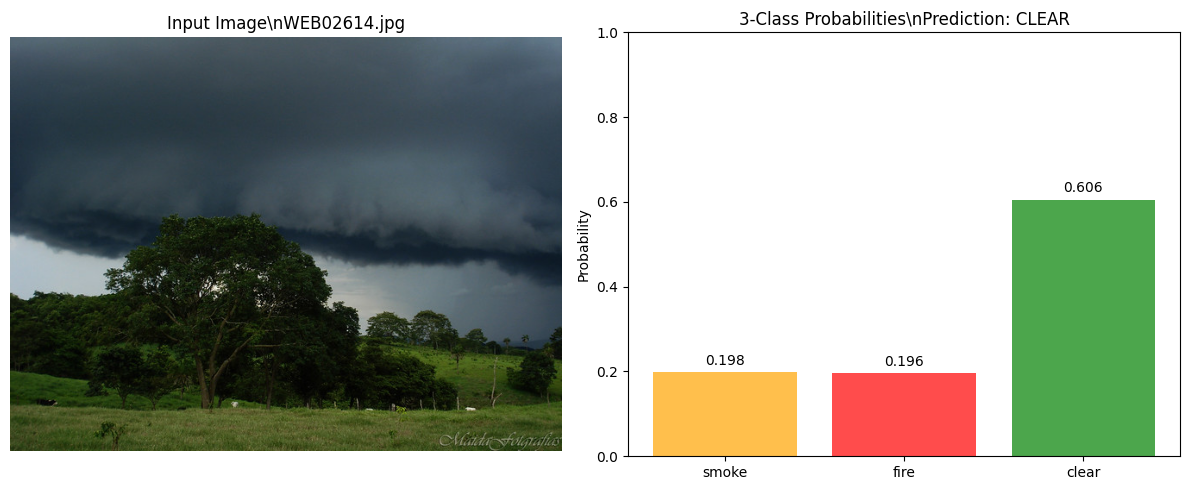


=== TESTING SINGLE IMAGE: data/dataset/image/WEB11799.jpg ===
Prediction: SMOKE
Probabilities:
  smoke: 0.528
  fire: 0.140
  clear: 0.332


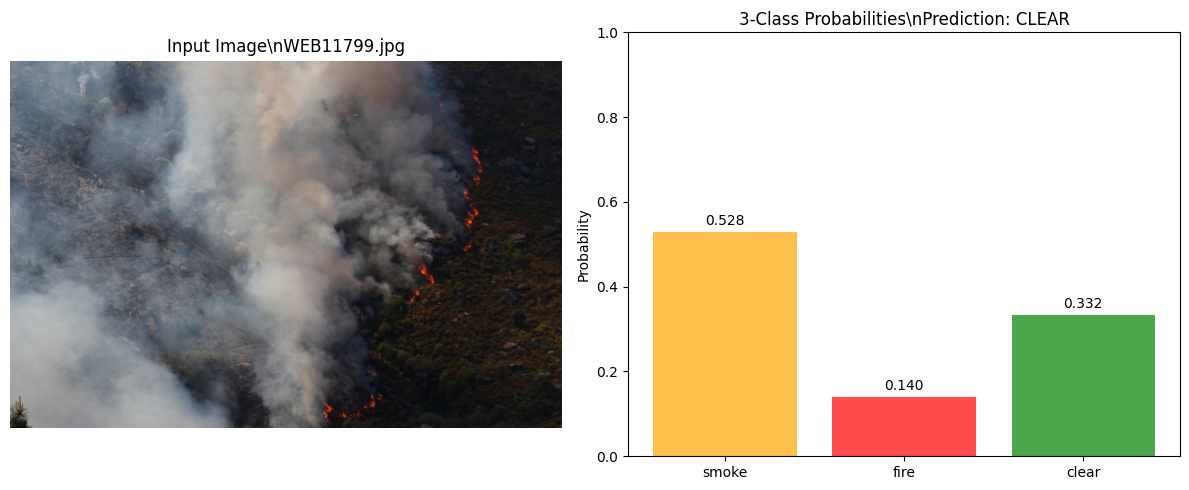


=== TESTING SINGLE IMAGE: data/dataset/image/WEB11518.jpg ===
Prediction: FIRE
Probabilities:
  smoke: 0.240
  fire: 0.426
  clear: 0.334


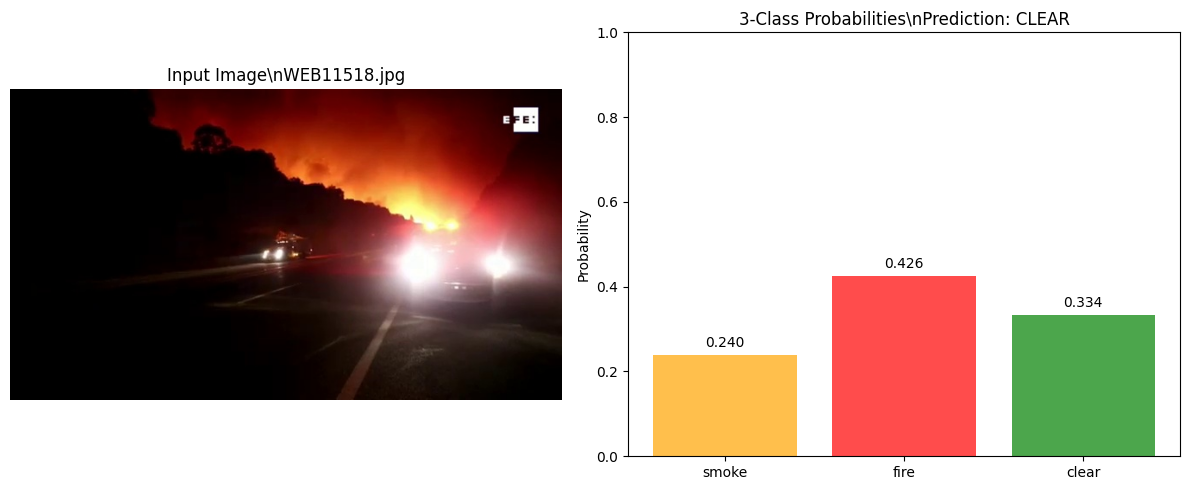


=== TESTING SINGLE IMAGE: data/dataset/image/WEB11692.jpg ===
Prediction: SMOKE
Probabilities:
  smoke: 0.755
  fire: 0.172
  clear: 0.072


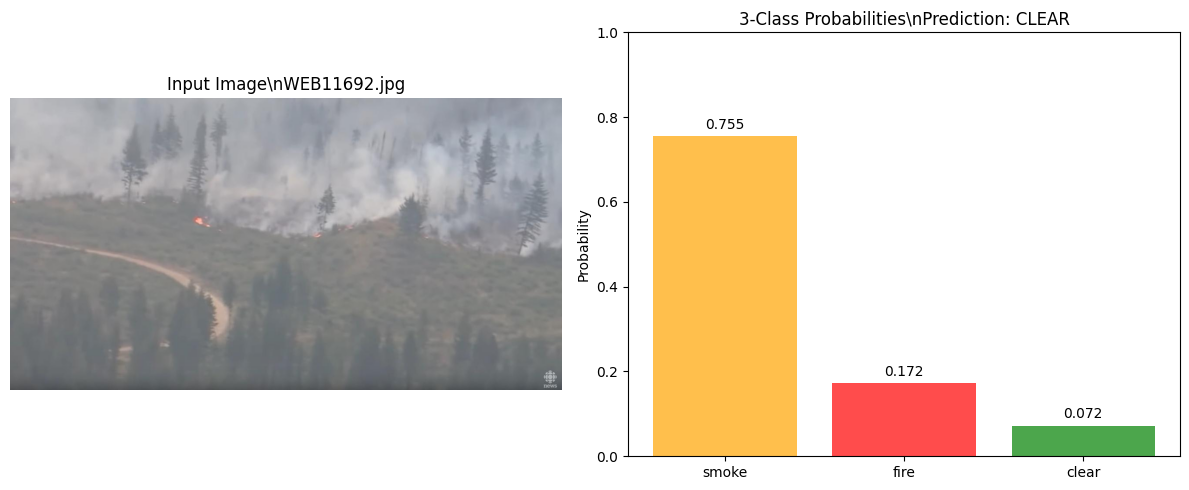

(np.int64(0),
 {'smoke': np.float64(0.755335487171046),
  'fire': np.float64(0.17229737914314025),
  'clear': np.float64(0.0723671336858138)})

In [40]:
# Testing on a specific image with 3-class model
test_image_path = "data/dataset/image/WEB02614.jpg"
test_single_image_3class(trained_pipeline, test_image_path)

test_image_path = "data/dataset/image/WEB11799.jpg"
test_single_image_3class(trained_pipeline, test_image_path)

test_image_path = "data/dataset/image/WEB11518.jpg"
test_single_image_3class(trained_pipeline, test_image_path)

test_image_path = "data/dataset/image/WEB11692.jpg"
test_single_image_3class(trained_pipeline, test_image_path)

Model loaded from smoke_fire_3class_model_full_final.pkl
Pipeline loaded from smoke_fire_3class_model_full_final.pkl

=== TESTING SINGLE IMAGE: data/dataset/image/WEB10324.jpg ===
Prediction: CLEAR
Probabilities:
  smoke: 0.350
  fire: 0.069
  clear: 0.581


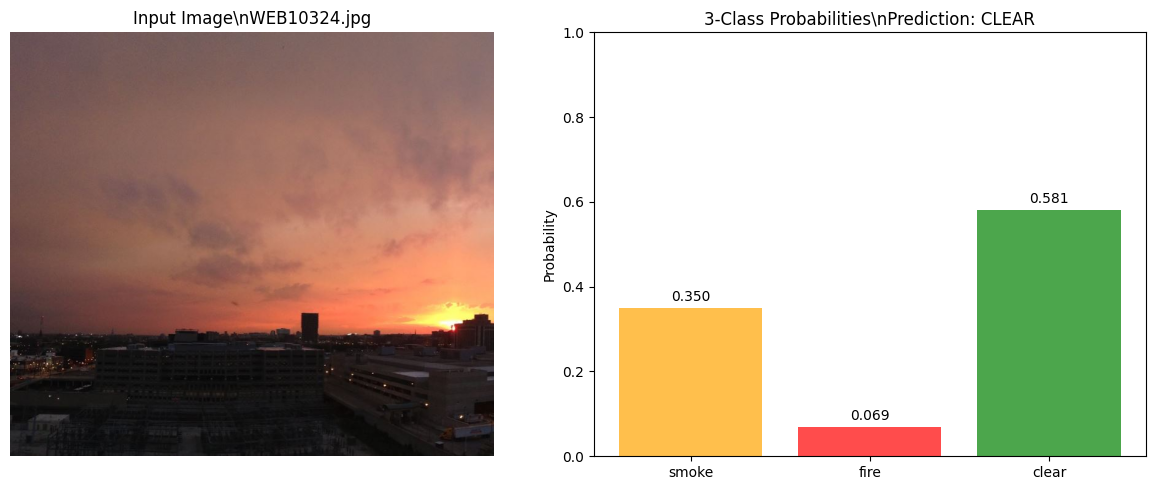

(np.int64(2),
 {'smoke': np.float64(0.3499244078733918),
  'fire': np.float64(0.06878697368526193),
  'clear': np.float64(0.5812886184413463)})

In [12]:
# Downloading trained model

model_path = "smoke_fire_3class_model_full_final.pkl"
pipline = SmokeDetectionPipeline()
model = pipline.load_pipeline(model_path)

test_image_path = "data/dataset/image/WEB10324.jpg"
test_single_image_3class(pipline, test_image_path)